In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

torch.cuda.empty_cache()

Device: cuda


In [2]:
import json 

config_name = 'utm_lr2e-5'
with open('./configs.json', 'r') as f: 
    config = json.load(f)[config_name]

config

{'train_data': 'SMG2020/ch/train.txt',
 'dev_data': 'SMG2020/ch/dev.txt',
 'scaler': 'joint',
 'model_type': 'bert',
 'model_name': 'statworx/bert-base-german-cased-finetuned-swiss',
 'lossfn': 'MAELoss',
 'save_predictions': True,
 'train_batch_size': 32,
 'max_seq_length': 128,
 'epochs': 50,
 'lr': 2e-05,
 'seed': 42,
 'projection': 'utm'}

In [3]:
class JointScaler():
	def __init__(self):
		self.means = None
		self.stddev = None

	def fit_transform(self, data):
		self.fit(data)
		return self.transform(data)
	
	def fit(self, data):
		self.means = np.mean(data, axis=0)
		centereddata = data - self.means
		self.stddev = np.std(centereddata)

	def transform(self, data):
		return (data - self.means) / self.stddev

	def inverse_transform(self, data):
		return (data * self.stddev) + self.means
	

scalers = {
	'independent': StandardScaler,
	'joint': JointScaler
}

scaler = scalers[config['scaler']]()

In [4]:
import utm

class GeolocationDataset(Dataset):
    def __init__(self, texts, coordinates):
        self.texts = texts
        self.coordinates = coordinates
        self.tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, return_tensors='pt')
        inputs = {key: val.squeeze() for key, val in inputs.items()}  # Remove batch dimension
        coords = torch.tensor(self.coordinates[idx], dtype=torch.float)
        return inputs, coords


col_names = ['lat', 'lon', 'text']

train_data = pd.read_csv('vardial-shared-tasks/SMG2020/ch/train.txt',
                         delimiter='\t', header=None, names=col_names)
dev_data = pd.read_csv('vardial-shared-tasks/SMG2020/ch/dev.txt',
                       delimiter='\t', header=None, names=col_names)

zone_number = 32
zone_letter = 'T'

def to_projection(df, config): 
    new_col_names = None
    if 'projection' in config: 
        match config['projection']: 
            case 'utm': 
                new_col_names = ['easting', 'northing', 'text']
                
                df[['lat', 'lon']] = df.apply(
                    lambda row: utm.from_latlon(
                        row['lat'], row['lon'], 
                        force_zone_number=zone_number, 
                        force_zone_letter=zone_letter)[:2], 
                    axis=1, result_type='expand')
                df.columns = new_col_names
            case _: 
                new_col_names = col_names
    else: 
        new_col_names = col_names

    return df, new_col_names
    

train_data, col_names = to_projection(train_data, config)
dev_data, _ = to_projection(dev_data, config)

train_coords = scaler.fit_transform(train_data[col_names[:2]].values)
train_dataset = GeolocationDataset(train_data['text'].tolist(), train_coords)
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)

Path('data/ch').mkdir(exist_ok=True)
with open('data/ch/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

dev_coords = scaler.transform(dev_data[col_names[:2]].values)
dev_dataset = GeolocationDataset(dev_data['text'].tolist(), dev_coords)
dev_loader = DataLoader(dev_dataset, batch_size=config['train_batch_size'], shuffle=False)

train_data

,easting,northing,text
0,381131.804856,5.230808e+06,Dr Chester Bennington isch tot 😔😔😔 #rip #linki...
1,439783.213452,5.189910e+06,Mini Fründin hed Lust uf Doktorspieli gha... ....
2,438114.281248,5.248831e+06,Slayer isch besser. Det han ich gescht mini Dr...
3,483390.191173,5.246306e+06,gaht au innere stund? bin grad am speck brate ...
4,427548.501983,5.248952e+06,sie: thy er: ? sie: thy= thank you er: player ...
...,...,...,...
22595,487904.163647,5.238515e+06,"Bin grad in Bus igstige, da seit de Buschauffe..."
22596,365623.151806,5.181110e+06,Rien ne surpassera Dragostea Din Tei de O-zone...
22597,543374.940570,5.199765e+06,het öpert au kei bock meh zum schaffa und lust...
22598,419850.326150,5.237936e+06,Oh wenn wedermol en jodel -5 het wos ned verdi...


In [5]:
class EastingOutOfRangeError(Exception):
    def __init__(self, message="Easting value out of valid UTM range"):
        super().__init__(message)

def check_utm_easting_range(array):
    min_easting = 100000  # Minimum valid easting value in meters
    max_easting = 999999  # Maximum valid easting value in meters

    if not ((min_easting <= array[:, 0]).all() and (array[:, 0] <= max_easting).all()):
        raise EastingOutOfRangeError("Easting values are out of the valid UTM range (100,000 m to 999,999 m)")

In [6]:
R = 6371  # Radius of Earth [km]

def haversine_distance(c1, c2):
    # c1 and c2 are arrays containing lat/lon in degrees
    c1 = np.radians(c1)
    c2 = np.radians(c2)
    dlat = c2[:, 0] - c1[:, 0]
    dlon = c2[:, 1] - c1[:, 1]

    a = np.sin(dlat / 2)**2 + np.cos(c1[:, 0]) * np.cos(c2[:, 0]) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c  # Distance [km]

def transform_to_latlon(preds, labels, config=config): 
    preds_trans = None
    labels_trans = None
    
    if 'projection' not in config: 
        return preds, labels
    
    match config['projection']: 
        case 'utm': 
            check_utm_easting_range(preds)
            check_utm_easting_range(labels)

            preds_trans = np.array(utm.to_latlon(
                 preds[:, 0], preds[:, 1], zone_number=zone_number, zone_letter=zone_letter))
            labels_trans = np.array(utm.to_latlon(
                 labels[:, 0], labels[:, 1], zone_number=zone_number, zone_letter=zone_letter))
            
            check_utm_easting_range(preds) 
            check_utm_easting_range(labels)
        case _: 
            return preds, labels

    return preds_trans, labels_trans

def median_distance(preds, labels, scaler=scaler, config=config):
    if scaler:
        preds = scaler.inverse_transform(preds)
        labels = scaler.inverse_transform(labels)

    if 'projection' in config:
        preds, labels = transform_to_latlon(preds, labels)
    return np.median(haversine_distance(preds, labels))

def mean_distance(preds, labels, scaler=scaler, config=config):    
    if scaler:
        preds = scaler.inverse_transform(preds)
        labels = scaler.inverse_transform(labels)
    
    if 'projection' in config:
        preds, labels = transform_to_latlon(preds, labels)
    return np.mean(haversine_distance(preds, labels))

In [7]:
from transformers import AutoModelForSequenceClassification, AdamW

model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=2)
optimizer = AdamW(model.parameters(), config['lr'])
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
from torch.utils.tensorboard import SummaryWriter
import datetime
import csv
import os

class TensorBoardCheckpoint:
    def __init__(self, log_dir, checkpoint_path, best_only=True):
        self.checkpoint_path = checkpoint_path
        self.best_metric = float('inf')
        self.best_only = best_only
        self.date_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = f'{log_dir}/{self.date_str}'
        self.writer = SummaryWriter(self.log_dir)
        self.metric_path = f'{self.log_dir}/metrics.csv'

    def log_metrics(self, metrics, step):
        for metric_name, metric_value in metrics.items():
            self.writer.add_scalar(metric_name, metric_value, step)

        with open(self.metric_path, 'a', newline='') as f:
            writer = csv.writer(f)
            if not os.path.isfile(self.metric_path):
                writer.writerow(metrics.keys())

            writer.writerow(metrics.values()) 

    def save_checkpoint(self, model, optimizer, epoch, metrics, scaler):
        checkpoint_path = f'{self.checkpoint_path}/{self.date_str}_best_model.pth'
        if metrics['Median_Distance/dev'] < self.best_metric:
            self.best_metric = metrics['Median_Distance/dev']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': metrics,
                'scaler': scaler
            }, checkpoint_path)
            self.writer.add_text('New_Best_Checkpoint', self.checkpoint_path, epoch)
            print(f"New best checkpoint saved at {self.checkpoint_path}")
        elif not self.best_only:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': metrics,
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")

    def close(self):
        self.writer.close()

In [9]:
import torch
from torch.nn import L1Loss
from tqdm import tqdm
import numpy as np

loss_function = L1Loss()

tb_checkpoint = TensorBoardCheckpoint(log_dir='data/ch/logs',
                                      checkpoint_path='data/ch/checkpoints')

def train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=10):
    loss_function = loss_function.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            # Forward pass
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)

            loss = loss_function(outputs.logits, labels)
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Training loss: {avg_train_loss:.4f}")

        # Evaluate on dev (validation)
        model.eval()
        dev_preds = []
        dev_labels = []
        with torch.no_grad():
            for batch in tqdm(dev_loader):
                inputs, labels = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                outputs = model(**inputs)
                dev_preds.append(outputs.logits.cpu().numpy())
                dev_labels.append(labels.cpu().numpy())

        dev_preds = np.vstack(dev_preds)
        dev_labels = np.vstack(dev_labels)

        median_dist = median_distance(dev_preds, dev_labels, scaler)
        mean_dist = mean_distance(dev_preds, dev_labels, scaler)

        metrics = {'Loss/train': avg_train_loss, 'Median_Distance/dev': median_dist, 'Mean_Distance/dev': mean_dist}
        tb_checkpoint.log_metrics(metrics, epoch)
        tb_checkpoint.save_checkpoint(model, optimizer, epoch, metrics, scaler)

with open('data/ch/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=config['epochs'])

tb_checkpoint.close()

100%|██████████| 707/707 [04:37<00:00,  2.54it/s]


Epoch 1/50 - Training loss: 0.4978


100%|██████████| 96/96 [00:18<00:00,  5.20it/s]


New best checkpoint saved at data/ch/checkpoints


 13%|█▎        | 92/707 [00:36<04:06,  2.50it/s]


KeyboardInterrupt: 

In [27]:
import os
import torch
import numpy as np
from tqdm import tqdm

checkpoint_dir = 'data/ch/checkpoints'

checkpoint_file = '20231112-231541'
config_name = 'utm_lr2e-5'
# checkpoint_file = config_name = '20231107-230346'

with open('./configs.json', 'r') as f: 
    config = json.load(f)[config_name]

train_data = pd.read_csv('vardial-shared-tasks/SMG2020/ch/train.txt',
                         delimiter='\t', header=None, names=['lat', 'lon', 'text'])

test_gold_data = pd.read_csv('vardial-shared-tasks/SMG2020/ch/test_gold.txt',
                       delimiter='\t', header=None, names=['lat', 'lon', 'text'])

test_gold_data, _ = to_projection(test_gold_data, config)

checkpoint_path = f'{checkpoint_dir}/{checkpoint_file}_best_model.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

print(checkpoint['metrics'])

checkpoint_scaler = checkpoint['scaler']
checkpoint_scaler.fit(train_data[['easting', 'northing']].values)
# checkpoint_scaler.fit(train_data[['lat', 'lon']].values)

test_gold_coords = checkpoint_scaler.transform(test_gold_data[['easting', 'northing']].values)
# test_gold_coords = checkpoint_scaler.transform(test_gold_data[['lat', 'lon']].values)
test_gold_dataset = GeolocationDataset(test_gold_data['text'].tolist(), test_gold_coords)
test_gold_loader = DataLoader(test_gold_dataset, batch_size=config['train_batch_size'], shuffle=False)

model.eval()

with torch.no_grad():
    test_preds = []
    for batch in tqdm(test_gold_loader):
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        outputs = model(**inputs)
        logits = outputs.logits
        test_preds.append(logits.cpu().numpy())

test_preds = np.concatenate(test_preds, axis=0)

results = {
    'median_distance': median_distance(test_gold_coords, test_preds, checkpoint_scaler, config),
    'mean_distance': mean_distance(test_gold_coords, test_preds, checkpoint_scaler, config)
}

print(f'{checkpoint_file}: {results}\n')



# for checkpoint_file in os.listdir(checkpoint_dir):
#     checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])

#     checkpoint_scaler = checkpoint['scaler']()
#     checkpoint_scaler.fit(train_data[['lat', 'lon']].values)

#     test_gold_coords = checkpoint_scaler.transform(test_gold_data[['lat', 'lon']].values)
#     test_gold_dataset = GeolocationDataset(test_gold_data['text'].tolist(), test_gold_coords)
#     test_gold_loader = DataLoader(test_gold_dataset, batch_size=config['train_batch_size'], shuffle=False)

#     model.eval()

#     with torch.no_grad():
#         test_preds = []
#         for batch in tqdm(test_gold_loader):
#             inputs, labels = batch
#             inputs = {k: v.to(device) for k, v in inputs.items()}
#             labels = labels.to(device)
            
#             outputs = model(**inputs)
#             logits = outputs.logits
#             test_preds.append(logits.cpu().numpy())

#     test_preds = np.concatenate(test_preds, axis=0)

#     results = {
#         'median_distance': median_distance(test_gold_coords, test_preds, checkpoint_scaler),
#         'mean_distance': mean_distance(test_gold_coords, test_preds, checkpoint_scaler)
#     }

#     print(f'{checkpoint_file}: {results}\n')

#     if results['median_distance'] < best_results['median_distance']:
#         best_checkpoint = checkpoint_file
#         best_results['median_distance'] = results['median_distance']
#         best_results['mean_distance'] = results['mean_distance']

# print("\nBest Checkpoint:", best_checkpoint)
# print("Best Results:", best_results)

{'Loss/train': 0.0786826800149266, 'Median_Distance/dev': 15.226538401122475, 'Mean_Distance/dev': 15.226538401122475}


KeyError: "None of [Index(['easting', 'northing'], dtype='object')] are in the [columns]"

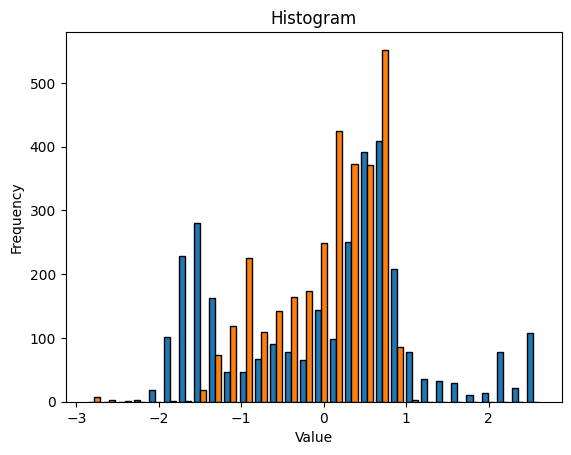

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate or load your data
data = np.random.normal(0, 1, 1000)  # Example: 1000 data points from a normal distribution

# Create a histogram
plt.hist(test_preds, bins=30, edgecolor='black')  # 'bins' define the number of intervals

# Adding labels and title for clarity
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the plot
plt.show()

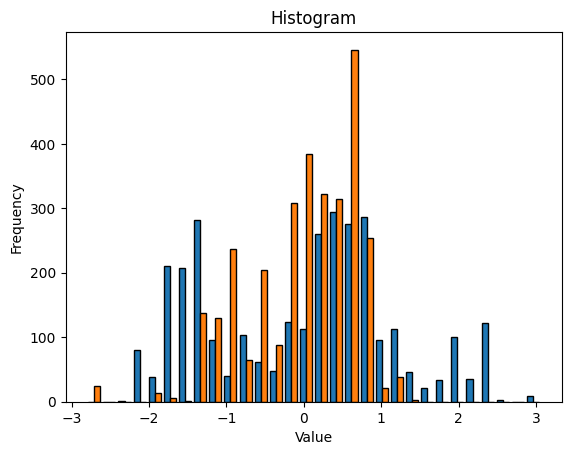

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate or load your data
data = np.random.normal(0, 1, 1000)  # Example: 1000 data points from a normal distribution

# Create a histogram
plt.hist(test_gold_coords, bins=30, edgecolor='black')  # 'bins' define the number of intervals

# Adding labels and title for clarity
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the plot
plt.show()

In [20]:
median_distance(test_gold_coords, test_preds, checkpoint_scaler, config)
# test_preds
# np.radians(test_gold_coords - test_preds)

16.44642298143306